In [1]:
import pickle
import pandas as pd
import nltk
import re
from matplotlib import pyplot as plt
import seaborn as sns
import itertools

In [2]:
exu_df = pd.read_pickle('../pickle_jar/EXU_split.pkl')
d20_df = pd.read_pickle('../pickle_jar/D20_split.pkl')

In [3]:
exu_df = exu_df.reset_index()
exu_df['player'] = exu_df['name']
exu_df.drop(columns='timestamp', inplace=True)
exu_df = exu_df.iloc[:, [0, 1, 7, 2, 3, 4, 5, 6]]

In [4]:
all_abbria = [exu_df, d20_df]
d20_df = pd.concat(all_abbria)
d20_df['player'] = d20_df['player'].str.upper()
d20_df = d20_df.rename(columns={'text': 'speech'})
d20_df

,index,name,player,speech,episode,inaudible_speech,nonspeech,season
0,0,AABRIA,AABRIA,Let's start with Robbie.,1,,,EXU
1,1,ROBBIE,ROBBIE,I'm so excited!,1,,,EXU
2,2,AABRIA,AABRIA,Yeah!,1,,,EXU
3,3,ROBBIE,ROBBIE,Whew!,1,,,EXU
4,4,AABRIA,AABRIA,Liam!,1,,,EXU
...,...,...,...,...,...,...,...,...
76015,1244,Aabria,AABRIA,your hard work. This is literally what we mean...,5,,,Misfits and Magic AP
76016,1245,Aabria,AABRIA,"collaborative storytelling, We all built this ...",5,,,Misfits and Magic AP
76017,1246,Aabria,AABRIA,"an honor and a privilege to get to build ""Misf...",5,,,Misfits and Magic AP
76018,1247,Aabria,AABRIA,"it right one time, thank God.",5,,,Misfits and Magic AP


In [5]:
d20_df['player'] = d20_df['player'].str.replace(r'AAABRIA', r'AABRIA', regex=True).astype('str') #correct 1 misspelling

Before I can get started with line counts and so on, we have to face off with a quirk of this dataset caused by the original format of the data before it was processed. In the seasons from Dimension 20 specifically, the data has one speech turn split up over multiple lines all the time, even mid-sentence.

Look at the intro from one episode below... This is undeniably one turn of speech for the DM, Aabria, but because of the formatting of the data, it's split over 10 DF rows!

In [6]:
ACO = d20_df[d20_df['season']=="ACOFF"]
ep1 = ACO[ACO['episode']=='10']
ep1.head(n=11)

,index,name,player,speech,episode,inaudible_speech,nonspeech,season
0,10,Aabria,AABRIA,"To the churlish Captain K.P. Hob, venerated s...",10,,,ACOFF
1,11,Aabria,AABRIA,"Goblin Court. To the master of ceremonies, Del...",10,,,ACOFF
2,12,Aabria,AABRIA,"the Court of Wonder. To BINX Choppley, sole su...",10,,,ACOFF
3,13,Aabria,AABRIA,"Craft. To the tenebrous Prince Andhera, scion ...",10,,,ACOFF
4,14,Aabria,AABRIA,"to the notorious Lords of the Wing, Lady Chirp...",10,,,ACOFF
5,15,Aabria,AABRIA,"Cluckingham, and Lord Squak Airavis, Earl of P...",10,,,ACOFF
6,16,Aabria,AABRIA,"archfey, we are delighted to welcome you to A ...",10,,,ACOFF
7,17,Aabria,AABRIA,"Hello, and welcome to Dimension 20's A Court o...",10,,,ACOFF
8,18,Aabria,AABRIA,"thrilling finale. I am your Dungeon Master, Aa...",10,,,ACOFF
9,19,Aabria,AABRIA,"one last time, are my pack of pixies. Say hi, ...",10,,,ACOFF


To take care of this, let's merge rows sharing information from the "name" column when in sequence

In [7]:
cond_d20 = d20_df.assign(key=d20_df['player'].ne(d20_df['player'].shift()).cumsum())\
        .groupby('key').agg({'player': 'first', 'speech': ' '.join})\
        .reset_index()

In [8]:
cond_d20=cond_d20.drop(8029) #odd row that had no value in any column

This condensed DF is what we'll work with, for these purposes, so that tokenizing and counts will be as accurate as possible. As a note, the uncondensed version of the dataframe contains 98923 rows, and the condensed version contains 64348  rows. 

To compare, let's check out that 10 line intro speech from above now. It looks much much better!

In [9]:
cond_d20.speech[34634]

' To the churlish Captain K.P. Hob, venerated soldier of the Goblin Court. To the Master of Ceremonies, Delloso de la Rue, pride of the Court of Wonder. To BINX Choppley, sole survivor of the Court of Craft. To the tenebrous Prince Andhera, scion of the Unseelie Court. And to the notorious Lords of the Wing, Lady Chirp Featherfowl, Countess of Cluckingham, and Lord Squak Airavis, Earl of Peckersburg. Honored archfey, we are delighted to welcome you to "A Court of Fey & Flowers". Greetings, and welcome to Dimension 20\'s "A Court of Fey & Flowers". I am your Dungeon Master, Aabria Iyengar, and with me, taking center stage, are my pack of pixies. Say hi, pack of pixies!'

### One step more

So the data here contains a LOT of data that doesn't belong to either DM or player. This is sometimes a guest who comes in to talk about the prouction of the show, maybe only a line or two, but in my early looks at working with the data, it's affecting the counts and visualizations quite a lot. To combat this, I'm going to select for only the main cast in the dataframe (confirmed by cast lists online). That will simplify the analysis quite a lot.

The results of this means we only lose 746 rows of data, but will be a much cleaner analysis thanks to it.

In [10]:
cond_d20 = cond_d20[cond_d20['player'].isin(['AABRIA', 'ROBBIE', 'LIAM', 'ASHLEY', 'MATT', 'AIMEE', 'OMAR', 'ANJALI', 'EMILY', 'LOU', 'OSCAR', 'BRENNAN', 'SURENA', 'RASHAWN', 'JASPER', 'SIOBHAN', 'IZZY', 'ERIKA', 'DANIELLE'])]

# Table of Contents

### Part 1

1. [Counting Lines](#Counting-Lines)
    - [Exploring Results](#Exploring-Results)<br>
    <br>
2. [Adding new columns](#Adding-new-columns)
    - [Word Counts](#Word-Counts-(per-spoken-line)
    - [Words per Speaker](#Total-words-per-speaker)
    - [Unique Words per Speaker](#Unique-Words-per-Speaker)
    - [Sentences and sentence length](#Sentences-and-sentence-length)<br>
<br>
3. [Initial Conlusions](#Initial-Conlusions)

### Part 2

1. [Dividing the Data](#Dividing-the-Data)<br>
<br>
2. [Re-measuring](#Re-measuring)
    - [Lines](#Lines)
    - [Word Count](#Word-Count)
    - [Sentence Length](#Sentence-Length)<br>
<br>
3. [Grouped Conclusions](#Grouped-Conclusions)

### Part 3

1. [Hedging](#Hedging)
2. [Jargon](#Jargon)
3. [Readability Metric](#Readability-Metric)
4. [Interruptions](#Interruptions)

## Counting Lines

In [11]:
lcount = cond_d20[['player', 'speech']].copy() #copy just these two cols over for now
lcount = lcount[lcount['speech'] != '']  #drop any rows with no value

In [12]:
spcount = pd.DataFrame(lcount.groupby(['player'])['speech'].count()) #speech count
spcount = spcount.reset_index()
spcount = spcount.sort_values('speech', ascending=False)
spcount.head(n=8)

,player,speech
0,AABRIA,19488
4,BRENNAN,5537
11,LOU,4293
1,AIMEE,4041
7,ERIKA,3106
12,MATT,2643
3,ASHLEY,2572
6,EMILY,2480


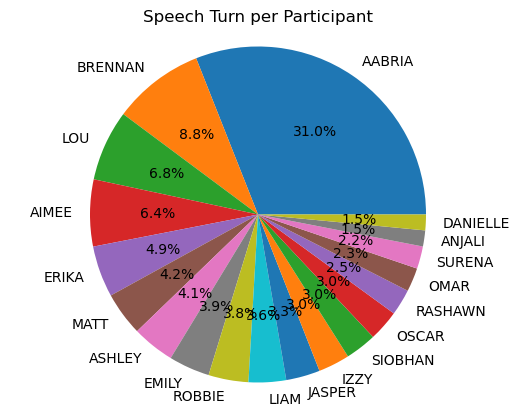

In [13]:
plt.pie(spcount['speech'], labels=spcount['player'], autopct='%1.1f%%')
plt.axis('equal')
plt.title('Speech Turn per Participant')
plt.show()

## Exploring Results 

write about attendance, number of seasons, different season lengths, how that makes this pie chart not the most informative, if there's only one constant from season to season of course she's going to have the biggest share of lines

## Adding new columns

Running through the base metrics we know and love.... word tokenizing & word counts, word types, word length, sentence count and sentence length. With these metrics available, the real interpretation can begin.

### Word Counts (per spoken line)

In [14]:
punctuations="!@#$%^&*()_-=+:;{}[]<>,.?/\''"

In [15]:
tokens = cond_d20.speech.map(nltk.word_tokenize)
cond_d20['tokens']=tokens         #create token column
cond_d20['nopunc']=cond_d20['tokens'].apply(lambda tokens: [w for w in tokens if w not in punctuations]) #list comprehend to remove toks
cond_d20 = cond_d20.drop('tokens', axis=1)     #drop that toks col, we don't actually want it

In [16]:
cond_d20['word_count'] = cond_d20.nopunc.map(len)   #count total tokens per line
cond_d20.head() 

,key,player,speech,nopunc,word_count
0,1,AABRIA,Let's start with Robbie.,"[Let, 's, start, with, Robbie]",5
1,2,ROBBIE,I'm so excited!,"[I, 'm, so, excited]",4
2,3,AABRIA,Yeah!,[Yeah],1
3,4,ROBBIE,Whew!,[Whew],1
4,5,AABRIA,Liam!,[Liam],1


### Total words per speaker

In [17]:
wcount = pd.DataFrame(cond_d20.groupby('player').word_count.sum())
wcount = wcount.reset_index()
wcount = wcount.sort_values('word_count', ascending=False)
wcount.head(n=8)

,player,word_count
0,AABRIA,307361
4,BRENNAN,113331
11,LOU,52439
7,ERIKA,37242
9,JASPER,26692
6,EMILY,25874
13,OMAR,23721
14,OSCAR,23609


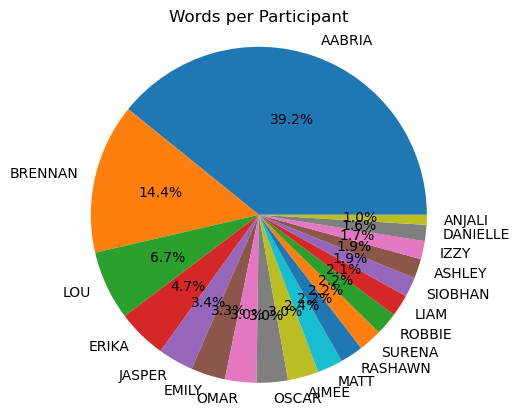

In [18]:
plt.pie(wcount['word_count'], labels=wcount['player'], autopct='%1.1f%%', labeldistance=1.1)
plt.axis('equal')
plt.title('Words per Participant')
plt.show()

ghjgh thouhgts

### Unique words per line

In [19]:
cond_d20['types'] = cond_d20['nopunc'].apply(lambda tokens: [w.lower() for w in tokens])
cond_d20['types'] = cond_d20['types'].apply(set)
cond_d20['type_count'] = cond_d20.types.map(len) 
cond_d20.head() #again to confirm, before punc removal type count for index 0 was 95

,key,player,speech,nopunc,word_count,types,type_count
0,1,AABRIA,Let's start with Robbie.,"[Let, 's, start, with, Robbie]",5,"{'s, let, robbie, with, start}",5
1,2,ROBBIE,I'm so excited!,"[I, 'm, so, excited]",4,"{excited, 'm, i, so}",4
2,3,AABRIA,Yeah!,[Yeah],1,{yeah},1
3,4,ROBBIE,Whew!,[Whew],1,{whew},1
4,5,AABRIA,Liam!,[Liam],1,{liam},1


### Unique Words per Speaker

jhk find out how to do this.... the other way won't work

### Sentences and sentence length

In [20]:
sents = cond_d20.speech.map(nltk.sent_tokenize)

In [21]:
sentlength = sents.map(len)    #number of sentences spoken per line
cond_d20['sents_count'] = sentlength

In [22]:
cond_d20['sents_count'].describe()

count    63602.000000
mean         1.461149
std          1.275981
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         76.000000
Name: sents_count, dtype: float64

Wow, CR had a lenghty 27 sentence speech, what is possibly this long?!

In [23]:
cond_d20[cond_d20['sents_count']==76]

,key,player,speech,nopunc,word_count,types,type_count,sents_count
28472,28473,AABRIA,"Damned by faint praise. Like, in comparison t...","[Damned, by, faint, praise, Like, in, comparis...",603,"{mean, watch, watered, she, frequently, should...",231,76


In [24]:
cond_d20.speech[28472]

" Damned by faint praise. Like, in comparison to any fey ever, how does a normal face do anything? And she walks over to you and looks at you and kind of takes you in, too, and gives a deep curtsy, well executed, well balanced, and you can see that her head is just sort of on a swivel as she looks around with wide eyes, just fully dazzled by everything she sees and everyone she meets.  It's a pleasure to meet you. Hi.  Hi, it's a pleasure to meet you as well. What was your name?  Wannessa.  Wannessa, that's right. So, Wannessa, how are you... How are you adjusting? Welcome.  Thank you. I'm good. Everything's just so grand. It really is breathtaking. You are lovely. Wow.  You are so weird.   And I like it—no, it's a compliment! I really enjoy it!  How am I weird? I don't—  Well, you have, like, these hands, but I feel like you should have more thumbs, because the thumb is the most useful finger on a hand, and you only have one, and you can't get more thumbs, you know?   Yeah, you're rig

### A closer look

I was fascinated by this and had to have a closer look at the original to verify this was all one speaker, and it is! The original transcript can be found [here](https://docs.google.com/document/d/e/2PACX-1vS6QswLcRjDTMSK57oj4o3WVKf6ykyoaNSqjBDuQgkPqJ_dkR0MB28U4NbUxFWE5g0oTJQJ7zAF-B44/pub), from Episode four. It's a back and forth between two NPCs (Non-Player Characters), both of course voices by the DM (since they are not player characters). Not one long speech by Aabria exactly.

In [25]:
avgsentlength = cond_d20.word_count/sentlength    #avg length of sentence per line or speech event
cond_d20['avg_sent_length']=avgsentlength
cond_d20['avg_sent_length'] = cond_d20['avg_sent_length'].fillna(0)
cond_d20['avg_sent_length'] = cond_d20['avg_sent_length'].map("{:.2f}".format)
cond_d20['avg_sent_length'] = cond_d20['avg_sent_length'].map(float)
cond_d20.head()

,key,player,speech,nopunc,word_count,types,type_count,sents_count,avg_sent_length
0,1,AABRIA,Let's start with Robbie.,"[Let, 's, start, with, Robbie]",5,"{'s, let, robbie, with, start}",5,1,5.0
1,2,ROBBIE,I'm so excited!,"[I, 'm, so, excited]",4,"{excited, 'm, i, so}",4,1,4.0
2,3,AABRIA,Yeah!,[Yeah],1,{yeah},1,1,1.0
3,4,ROBBIE,Whew!,[Whew],1,{whew},1,1,1.0
4,5,AABRIA,Liam!,[Liam],1,{liam},1,1,1.0


Another closer look...

In [26]:
cond_d20['avg_sent_length'].describe()

count    63602.000000
mean         7.262841
std          7.327353
min          0.000000
25%          3.000000
50%          5.000000
75%          9.000000
max        133.000000
Name: avg_sent_length, dtype: float64

In [27]:
cond_d20[cond_d20['avg_sent_length']==133]

,key,player,speech,nopunc,word_count,types,type_count,sents_count,avg_sent_length
35882,35883,OMAR,"It can be really simple, where you just let w...","[It, can, be, really, simple, where, you, just...",133,"{actually, down, the, guess, these, more, othe...",77,1,133.0


In [28]:
cond_d20.speech[35882]

" It can be really simple, where you just let water drip down the glowworm trails, because glowworms have that little sticky lines of just, ba-ba-ba-ba, and that's how they trap flies and stuff in caves, and it's letting the water drop, but you kind of tap the worms so they have different lengths so the water drops at different heights to make different noises, but you can actually also guide different trails of water, similar to a synthesizer, but you just encourage more water down certain lines so that you have a pentatonic beat going here, and then you have sort of a melody going on with these other worms, and that's kind of just, I don't know, I guess it's a little thing that never came up."

Very similarly to the longest sentence in the Critical Role data, this is quite a run-on. Again, though, it seems like an accurate transcription of the speech itself. A focus on capturing the reality of what Omar was saying as he delivered a kind of rambling story about glowworms rather than grammaticality of written language.

In [29]:
sentcount = pd.DataFrame(cond_d20.groupby('player').sents_count.sum())
sentcount = sentcount.reset_index()
sentcount = sentcount.sort_values('sents_count', ascending=False)

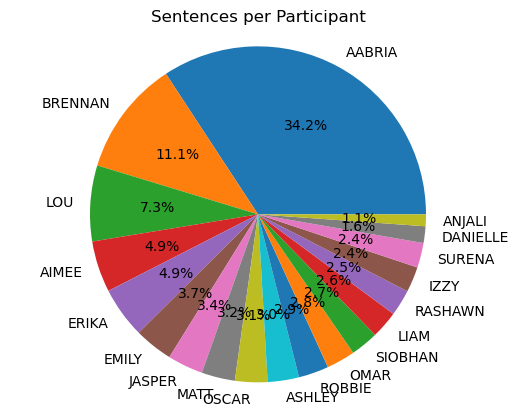

In [30]:
plt.pie(sentcount['sents_count'], labels=sentcount['player'], autopct='%1.1f%%')
plt.axis('equal')
plt.title('Sentences per Participant')
plt.show()

### Average sentence length per speaker

In [31]:
slen = pd.DataFrame(cond_d20.groupby('player').avg_sent_length.mean())
slen = slen.reset_index()
slen['avg_sent_length'] = slen['avg_sent_length'].map("{:.2f}".format)
slen['avg_sent_length'] = slen['avg_sent_length'].map(float)
slen = slen.sort_values('avg_sent_length', ascending=False)

In [32]:
#avgsents = slen[slen['avg_sent_length']>15]

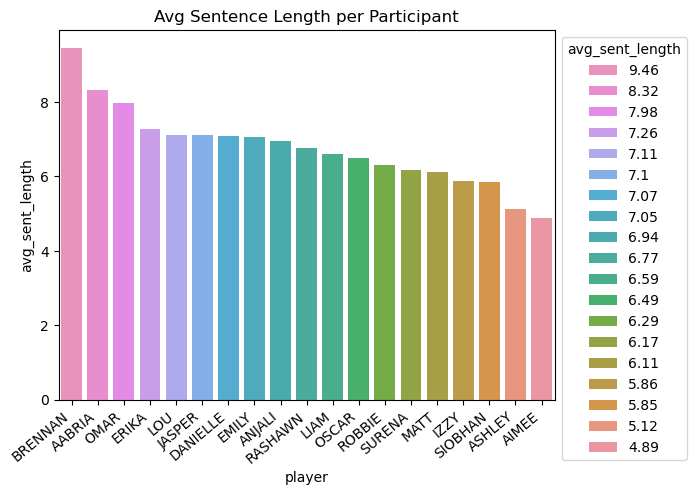

In [33]:
slenplot = sns.barplot(slen, x="player", y="avg_sent_length", hue="avg_sent_length", dodge=False)
slenplot.set_title("Avg Sentence Length per Participant")
slenplot.set_xticklabels(slenplot.get_xticklabels(), rotation=40, ha="right")
sns.move_legend(slenplot, "upper left", bbox_to_anchor=(1, 1), reverse=True)
plt.show()

think about how to deal with this more too

## Initial Conlusions

## Dividing the Data

In [34]:
women_df = cond_d20[cond_d20['player'].isin(['ASHLEY', 'AIMEE', 'ANJALI', 'EMILY', 'SURENA', 'RASHAWN', 'SIOBHAN', 'IZZY', 'ERIKA', 'DANIELLE'])]

In [35]:
men_df = cond_d20[cond_d20['player'].isin(['ROBBIE', 'LIAM', 'MATT', 'OMAR', 'LOU', 'OSCAR', 'BRENNAN', 'JASPER'])]

In [36]:
aabria =  pd.DataFrame(cond_d20[cond_d20['player']=='AABRIA'])

## Re-measuring

Who is talking more between groups, who says more words, has longer sentences? 

I'm going to re-measure for total line counts, word counts, and average sentence lengths.

For these measurements, to get the true scope of *total* counts, I created an "other" category, for all participants who are not the main cast. It creates a minimal dent, but I wanted an accurate measurement. 

### Lines

In [37]:
#total number of lines/speech turns for all women
womenlcount = women_df[['speech']].copy()
womenlcount = womenlcount[womenlcount['speech'] != '']
womenlcount['val'] = 'women'
womenlcount = pd.DataFrame(womenlcount['speech'].groupby(womenlcount['val']).count())
womenlcount = womenlcount.reset_index()
womenlcount['speech']

0    20860
Name: speech, dtype: int64

In [38]:
#total number of lines/speech turns for men, not including the DM
menlcount = men_df[['speech']].copy()
menlcount = menlcount[menlcount['speech'] != '']
menlcount['val'] = 'men'
menlcount = pd.DataFrame(menlcount['speech'].groupby(menlcount['val']).count())
menlcount = menlcount.reset_index()
menlcount['speech']

0    22514
Name: speech, dtype: int64

In [39]:
aablcount = aabria[['speech']].copy()
aablcount = aablcount[aablcount['speech'] != '']
aablcount['val'] = 'DM'
aablcount = pd.DataFrame(aablcount['speech'].groupby(aablcount['val']).count())
aablcount = aablcount.reset_index()
aablcount['speech']

0    19488
Name: speech, dtype: int64

In [40]:
mnw=[womenlcount, menlcount]
dmnw = [womenlcount, menlcount, aablcount]

mnwlines = pd.concat(mnw)
all_lines = pd.concat(dmnw)

Text(0.5, 1.0, 'Total Lines by Gender (Including DM)')

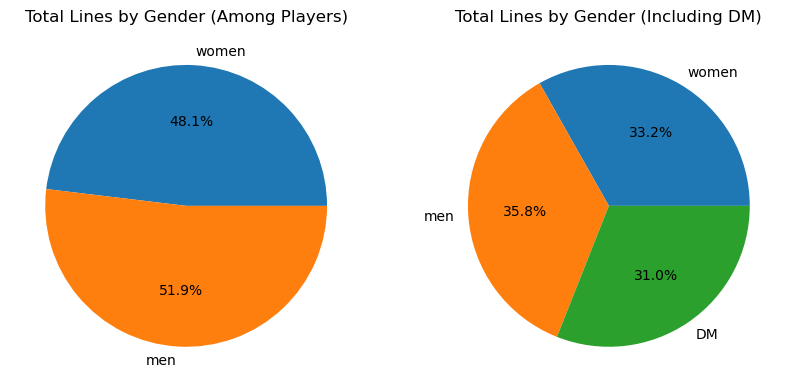

In [41]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))

labels = mnwlines['val']
values = mnwlines['speech']
ax1.pie(values,labels = labels, autopct = '%1.1f%%') #plot first pie
ax1.set_title('Total Lines by Gender (Among Players)')


labels = all_lines['val']
values = all_lines['speech']
ax2.pie(values,labels = labels, autopct = '%1.1f%%') #plot second pie
ax2.set_title('Total Lines by Gender (Including DM)')

### Line % of totals

### Word Count

In [42]:
womwcount = women_df[['word_count']].copy()
womwcount['val']='women'
womwcount = pd.DataFrame(womwcount['word_count'].groupby(womwcount['val']).sum())
womwcount = womwcount.reset_index()
womwcount.word_count

0    184429
Name: word_count, dtype: int64

In [43]:
menwcount = men_df[['word_count']].copy()
menwcount['val']='men'
menwcount = pd.DataFrame(menwcount['word_count'].groupby(menwcount['val']).sum())
menwcount = menwcount.reset_index()
menwcount.word_count

0    292785
Name: word_count, dtype: int64

In [44]:
dmwcount = aabria[['word_count']].copy()
dmwcount['val']='DM'
dmwcount = pd.DataFrame(dmwcount['word_count'].groupby(dmwcount['val']).sum())
dmwcount = dmwcount.reset_index()
dmwcount.word_count

0    307361
Name: word_count, dtype: int64

In [45]:
mnwc = [womwcount, menwcount]
dmnwc = [womwcount, menwcount, dmwcount]

mnwcount = pd.concat(mnwc)
dmnwcount = pd.concat(dmnwc)

Text(0.5, 1.0, 'Total Words by Gender (Including DM)')

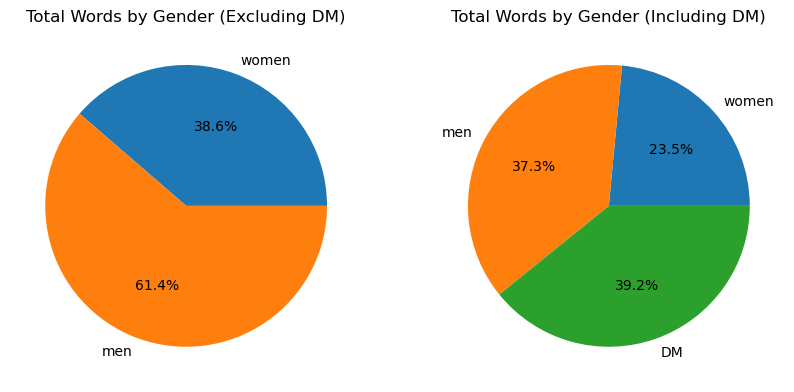

In [46]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))

labels = mnwcount['val']
values = mnwcount['word_count']
ax1.pie(values,labels = labels, autopct = '%1.1f%%') #plot first pie
ax1.set_title('Total Words by Gender (Excluding DM)')


labels = dmnwcount['val']
values = dmnwcount['word_count']
ax2.pie(values,labels = labels, autopct = '%1.1f%%') #plot second pie
ax2.set_title('Total Words by Gender (Including DM)')

### Word % of totals

### Sentence Length

In [47]:
womscount = women_df[['avg_sent_length']].copy()
womscount['val']='women'
womscount = pd.DataFrame(womscount['avg_sent_length'].groupby(womscount['val']).mean())
womscount = womscount.reset_index()
womscount.avg_sent_length

0    6.114863
Name: avg_sent_length, dtype: float64

In [48]:
menscount = men_df[['avg_sent_length']].copy()
menscount['val']='men'
menscount = pd.DataFrame(menscount['avg_sent_length'].groupby(menscount['val']).mean())
menscount = menscount.reset_index()
menscount.avg_sent_length

0    7.415366
Name: avg_sent_length, dtype: float64

In [49]:
aabscount = aabria[['avg_sent_length']].copy()
aabscount['val']='DM'
aabscount = pd.DataFrame(aabscount['avg_sent_length'].groupby(aabscount['val']).mean())
aabscount = aabscount.reset_index()
aabscount.avg_sent_length

0    8.319386
Name: avg_sent_length, dtype: float64

In [50]:
dmnws = [womscount, menscount, aabscount]

dmnwslen = pd.concat(dmnws)

dmnwslen['avg_sent_length'] = dmnwslen['avg_sent_length'].map("{:.2f}".format)
dmnwslen['avg_sent_length'] = dmnwslen['avg_sent_length'].map(float)

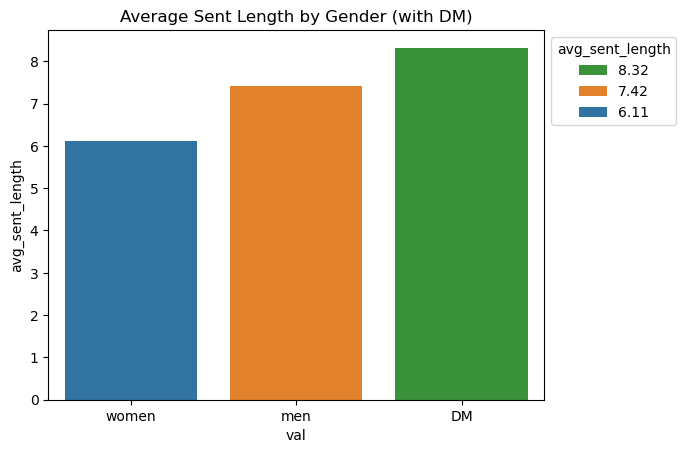

In [51]:
dmnwslenplot = sns.barplot(dmnwslen, x="val", y="avg_sent_length", hue="avg_sent_length", dodge=False)
dmnwslenplot.set_title("Average Sent Length by Gender (with DM)")
sns.move_legend(dmnwslenplot, "upper left", bbox_to_anchor=(1, 1), reverse=True)
plt.show()

### % of totals

## Grouped Conclusions

## Hedging

In [52]:
hedge = ['maybe', 'might', 'perhaps', 'possibly', 'appears', 'seems', 'suggests', 'tends']  #hedging words

In [53]:
womlist = women_df['speech'].tolist()   #get the speech column from the women only df
womlist = [w.lower() if isinstance(w, str) else w for w in womlist]   #if it is a str, lowercase and return full text
womtoks = [nltk.word_tokenize(s) for s in womlist]   #tokenize
womtoks = list(itertools.chain(*womtoks))  #flatten list of lists into one list

In [56]:
womhedg = [w for w in womtoks if w in hedge]  #return list of words in women_df speech that appear in hedging list
len(womhedg)   #get total count

506

In [57]:
print(women_df['speech'].str.count(r'I guess').sum())   #get count for each hedging phrase
print(women_df['speech'].str.count(r'I think').sum())
print(women_df['speech'].str.count(r'[C|c]ould be').sum())

120
540
42


In [58]:
menlist = men_df['speech'].tolist()
menlist = [w.lower() if isinstance(w, str) else w for w in menlist]
mentoks = [nltk.word_tokenize(s) for s in menlist]
mentoks = list(itertools.chain(*mentoks))

In [59]:
menhedg = [w for w in mentoks if w in hedge]
len(menhedg)

627

In [60]:
print(men_df['speech'].str.count(r'I guess').sum())
print(men_df['speech'].str.count(r'I think').sum())
print(men_df['speech'].str.count(r'[C|c]ould be').sum())

99
1063
41


In [61]:
aablist = aabria['speech'].tolist()
aablist = [w.lower() if isinstance(w, str) else w for w in aablist]
aabtoks = [nltk.word_tokenize(s) for s in aablist]
aabtoks = list(itertools.chain(*aabtoks))

In [62]:
aabhedg = [w for w in aabtoks if w in hedge]
len(aabhedg)

273

In [63]:
print(aabria['speech'].str.count(r'I guess').sum())
print(aabria['speech'].str.count(r'I think').sum())
print(aabria['speech'].str.count(r'[C|c]ould be').sum())

38
371
40


### Hedging Conclusions

## Jargon

In [64]:
jargon = pd.read_pickle('../pickle_jar/jargonlist.pkl') #jargon list as created in PHB_Jargon notebook
jargon[453:458]

['undercommon', 'rerolls', 'abbathor', 'tharizdun', 'caltrops']

In [65]:
womjarg = [w for w in womtoks if w in jargon]  #using the same method as hedging, list comprehend for jargon examples
len(womjarg)

24

In [66]:
menjarg = [w for w in mentoks if w in jargon]
len(menjarg)

62

In [68]:
aabjarg = [w for w in aabtoks if w in jargon]
len(aabjarg)

62

### Jargon Frequency

### Jargon Results

In [69]:
from wordcloud import WordCloud

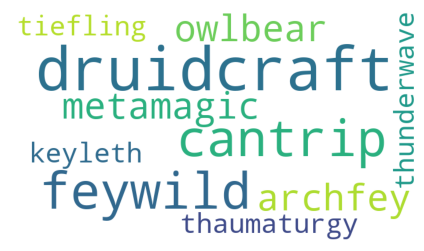

In [78]:
unique_string=(" ").join(womjarg)
wordcloud = WordCloud(background_color='white', width = 700, height = 400).generate(unique_string)
plt.figure(figsize=(8,3))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("your_file_name"+".png", bbox_inches='tight')
plt.show()

### Women

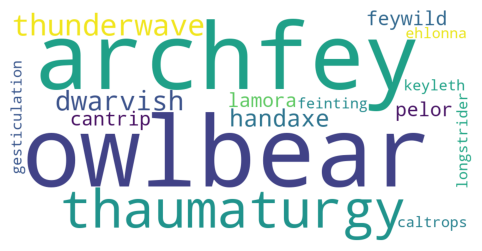

In [79]:
unique_string=(" ").join(menjarg)
wordcloud = WordCloud(background_color='white', width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(8,3))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Men

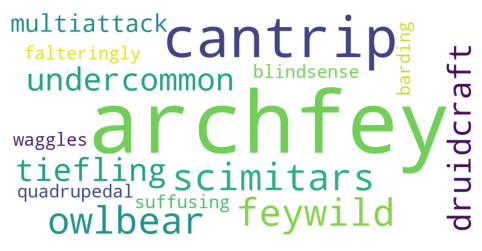

In [80]:
unique_string=(" ").join(aabjarg)
wordcloud = WordCloud(background_color='white', width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(8,3))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### DM

## Readability Metric

### Flesch–Kincaid readability test

Reminder that the calculation for the readability score is:<br>
<img src=https://wikimedia.org/api/rest_v1/media/math/render/svg/bd4916e193d2f96fa3b74ee258aaa6fe242e110e>

In [81]:
from nltk.tokenize import SyllableTokenizer
import warnings
warnings.filterwarnings('ignore')

In [82]:
SSP = SyllableTokenizer()

### Women

In [83]:
wnopunc = [w for w in womtoks if w not in punctuations]  #removing punctuation for syl tokenizer
wsyls = [SSP.tokenize(w) for w in wnopunc] #syl tokenize for each tokenized word
wsylcount = [len(w) for w in wsyls]   #count syllable per word in full list
sum(wsylcount)  #total count all syllables for women

253214

In [ ]:
#readability calculation for women speech

206.853-(1.015*(865969/145926))-(84.6*(1182614/865969))

In [ ]:
#grade score for women speech 

(0.39*(865969/145926))+(11.8*(1182614/865969))-15.59

### Men

In [84]:
mnopunc = [w for w in mentoks if w not in punctuations]  
msyls = [SSP.tokenize(w) for w in mnopunc] 
msylcount = [len(w) for w in msyls]   
sum(msylcount) 

409031

In [ ]:
#readability calculation for men speech

206.853-(1.015*(1349707/211423))-(84.6*(1861455/1349707))

In [ ]:
#grade score for men speech 

(0.39*(1349707/211423))+(11.8*(1861455/1349707))-15.59

### DM

In [85]:
dmnopunc = [w for w in aabtoks if w not in punctuations]  
dmsyls = [SSP.tokenize(w) for w in dmnopunc] 
dmsylcount = [len(w) for w in dmsyls]   
sum(dmsylcount) 

444592

In [ ]:
#readability calculation for DM speech

206.853-(1.015*(1385768/149314))-(84.6*(2037971/1385768))

In [ ]:
#grade score for DM speech 

(0.39*(1385768/149314))+(11.8*(2037971/1385768))-15.59

## Readability Conclusions

FINISH THIS

something about how to take this very cautiously because it's for reading not for spoken lang but it's interesting to see

## Interruptions

In [75]:
cond_d20[cond_d20['speech'].str.contains(r'[K|k]eyleth')]

,key,player,speech,nopunc,word_count,types,type_count,sents_count,avg_sent_length
4296,4297,LIAM,"Keyleth of the Air Ashari, our-- our leader","[Keyleth, of, the, Air, Ashari, our, --, our, ...",9,"{air, of, --, the, leader, ashari, our, keyleth}",8,1,9.0
4303,4304,ASHLEY,"Keyleth, did you say? If she was able to use a...","[Keyleth, did, you, say, If, she, was, able, t...",21,"{she, should, we, for, if, did, keep, maybe, t...",21,2,10.5
